# Digital Filtering

In [1]:
!pip install astroML

     |████████████████████████████████| 112kB 5.9MB/s 
  Created wheel for astroML: filename=astroML-0.4.1-cp36-none-any.whl size=128663 sha256=60e571ae5082b1f8aa7019fff458f178eb99e32606726974bea905f55804964d
  Stored in directory: /root/.cache/pip/wheels/7c/f2/f3/eb817cfb31b4445358dd7dda2434e02003f72801edabc38c97
Successfully built astroML


Author: Jake VanderPlas  
License: BSD  

The figure produced by this code is published in the textbook  
*"Statistics, Data Mining, and Machine Learning in Astronomy"* (2013)  

For more information, see http://astroML.github.com  
To report a bug or issue, use the following forum: https://groups.google.com/forum/#!forum/astroml-general  

## Introduction
**Digital filtering** aims to reduce noise in time series data, or to compress data. Common examples
include low-pass filtering, where high frequencies are suppressed, high-pass filtering, where low
frequencies are suppressed, passband filtering, where only a finite range of frequencies is admitted,
and a notch filter, where a finite range of frequencies is blocked. We will use a few examples to illustrate the most common
applications of filtering.  
Fourier analysis is one of the most useful tools for performing filtering. Numerous other techniques can be found in signal processing literature, including approaches based on the wavelets discussed in the modeling toolkit notebook.   
  
We emphasize that filtering always decreases the information content of data (despite making
it appear less noisy). As we have already learned throughout previous chapters, when model
parameters are estimated from data, raw (unfiltered) data should be used. In some sense, this is
an analogous situation to binning data to produce a histogram-while very useful for visualization, estimates of model parameters can become biased if one is not careful.

### Import packages and data
In this notebook, we are going to explore the astroML.filters. The functions we mainly use are savitzky_golay, and wiener_filter. The spectrum of a white dwarf data imported for this notebook is from Sloan Digital Sky
Survey (SDSS).

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

from astroML.fourier import PSD_continuous
from astroML.datasets import fetch_sdss_spectrum

from scipy import optimize, fftpack, interpolate
from astroML.fourier import IFT_continuous
from astroML.filters import savitzky_golay, wiener_filter
from astroML.filters import min_component_filter

## 1. Low-pass filters
The power spectrum for common Gaussian noise is 
at and will extend to frequencies as high as
the Nyquist limit, $f_N = 1=(2\Delta t)$. If the data are band limited to a lower frequency, $f_c < f_N$, then
they can be smoothed without much impact by suppressing frequencies $|f| > f_c$. Given a filter
in frequency space, $\Phi (f)$, we can obtain a smoothed version of data by taking the inverse Fourier
transform of
$$\hat{Y}(f)=Y(f) \Phi(f)$$
where $Y(f)$ is the discrete Fourier transform of data. At least in principle, we could simply set
$\Phi(f)$ to zero for $|f| > f_c$, but this approach would result in ringing (i.e., unwanted oscillations)
in the signal. Instead, the optimal filter for this purpose is constructed by minimizing the MISE
between $\hat{Y}(f)$ and $Y(f)$ (for detailed derivation see NumRec) and is called the **Wiener filter**:
$$\Phi(f) = \frac{P_S(f)}{P_S(f)+P_N(f)}$$
Here $P_S(f)$ and $P_N(f)$ represent components of a two-component (signal and noise) fit to the
PSD of input data, $PSD_Y (f) = P_S(f) + P_N(f)$, which holds as long as the signal and noise are
uncorrelated. We will see how the filtering works in the example below.

### Create the noisy data
We are going to generate a set of noisy data as the input signal, on which we apply filters. The figure below shows the input data (200 evenly spaced points) with a narrow Gaussian peak centered at x = 20.

Text(0, 0.5, 'flux')

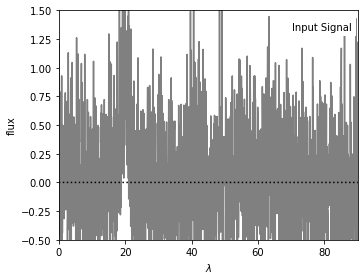

In [ ]:
# Create the noisy data
np.random.seed(5)
N = 2000
dt = 0.05

t = dt * np.arange(N)
h = np.exp(-0.5 * ((t - 20.) / 1.0) ** 2)
hN = h + np.random.normal(0, 0.5, size=h.shape)

# Plot the results
N = len(t)
Df = 1. / N / (t[1] - t[0])
f = fftpack.ifftshift(Df * (np.arange(N) - N / 2))
HN = fftpack.fft(hN)

fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(wspace=0.05, hspace=0.35,
                    bottom=0.1, top=0.95,
                    left=0.12, right=0.95)

# First plot: noisy signal
ax = fig.add_subplot(111)
ax.plot(t, hN, '-', c='gray')
ax.plot(t, np.zeros_like(t), ':k')
ax.text(0.98, 0.95, "Input Signal", ha='right', va='top',
        transform=ax.transAxes, bbox=dict(fc='w', ec='none'))

ax.set_xlim(0, 90)
ax.set_ylim(-0.5, 1.5)

ax.xaxis.set_major_locator(plt.MultipleLocator(20))
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel('flux')

### Set up the Wiener filter
We fit a model to the PSD consisting of the sum of a gaussian and white noise using **Wiener filter**. We will see this method in the later sections in this notebook.  

In [ ]:
N = 2000

Df = 1. / N / dt
f = fftpack.ifftshift(Df * (np.arange(N) - N / 2))
HN = fftpack.fft(hN)

# apply the Wiener filter
h_smooth, PSD, P_S, P_N, Phi = wiener_filter(t, hN, return_PSDs=True)

### Set up the Savitzky-Golay filter
We use a fourth-order **Savitzky-Golay** filter with a window size of $\Delta \lambda = 10$ to filter the vales. 
The Savitzky-Golay filter is a very simple but powerful method as a low-pass filter. It fits low-order polynomials
to data (in the time domain) using sliding windows (it is also known as the least-squares filter).
For a detailed discussion, see NumRec.

In [ ]:
# apply the Savitzky-Golay filter
h_sg = savitzky_golay(hN, window_size=201, order=4, use_fft=False)

### Show filtered signal
Plot below shows noisy signal after filtering. 
* Result from Wiener filter is shown in black.
* Result from Savitzky-Golay filter is shown in gray.  

The Gaussian peak at x=20 is clearly seen in both curves.

Text(0, 0.5, 'flux')

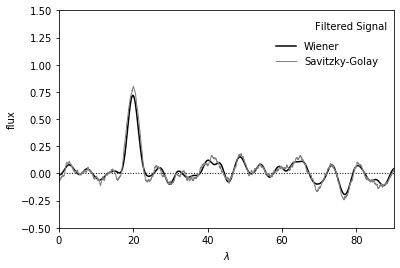

In [ ]:
# Second plot: filtered signal
ax = plt.subplot(111)
ax.plot(t, np.zeros_like(t), ':k', lw=1)
ax.plot(t, h_smooth, '-k', lw=1.5, label='Wiener')
ax.plot(t, h_sg, '-', c='gray', lw=1, label='Savitzky-Golay')

ax.text(0.98, 0.95, "Filtered Signal", ha='right', va='top',
        transform=ax.transAxes)
ax.legend(loc='upper right', bbox_to_anchor=(0.98, 0.9), frameon=False)

ax.set_xlim(0, 90)
ax.set_ylim(-0.5, 1.5)

ax.xaxis.set_major_locator(plt.MultipleLocator(20))
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel('flux')

### Show filtered PSD
* The upper panel shows the input power spectral density (PSD) distribution.  
* The lower panel shows the Wiener-filtered power spectral density (PSD) distributions.  

The two curves in the upper panel represent two-component fit to PSD given by equation
$$\Phi(f) = \frac{P_S(f)}{P_S(f)+P_N(f)}$$

Text(0, 0.5, '$PSD(f)$')

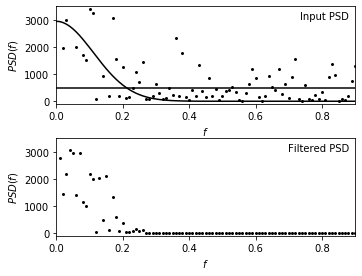

In [ ]:
# Plot the results
N = len(t)
Df = 1. / N / (t[1] - t[0])
f = fftpack.ifftshift(Df * (np.arange(N) - N / 2))
HN = fftpack.fft(hN)

fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(wspace=0.05, hspace=0.35,
                    bottom=0.1, top=0.95,
                    left=0.12, right=0.95)

# Third plot: Input PSD
ax = fig.add_subplot(211)
ax.scatter(f[:N // 2], PSD[:N // 2], s=9, c='k', lw=0)
ax.plot(f[:N // 2], P_S[:N // 2], '-k')
ax.plot(f[:N // 2], P_N[:N // 2], '-k')

ax.text(0.98, 0.95, "Input PSD", ha='right', va='top',
        transform=ax.transAxes)

ax.set_ylim(-100, 3500)
ax.set_xlim(0, 0.9)

ax.yaxis.set_major_locator(plt.MultipleLocator(1000))
ax.xaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.set_xlabel('$f$')
ax.set_ylabel('$PSD(f)$')

# Fourth plot: Filtered PSD
ax = fig.add_subplot(212)
filtered_PSD = (Phi * abs(HN)) ** 2
ax.scatter(f[:N // 2], filtered_PSD[:N // 2], s=9, c='k', lw=0)

ax.text(0.98, 0.95, "Filtered PSD", ha='right', va='top',
        transform=ax.transAxes)

ax.set_ylim(-100, 3500)
ax.set_xlim(0, 0.9)

ax.yaxis.set_major_locator(plt.MultipleLocator(1000))
ax.xaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.set_xlabel('$f$')
ax.set_ylabel('$PSD(f)$')

### Wiener Filter and kernel smoothing Connection
There is an interesting connection between the kernel density estimation method discussed in the KDE notebook
and Wiener filtering. By the convolution theorem, the Wiener-filtered result is equivalent to the
convolution of the unfiltered signal with the inverse Fourier transform of $\Phi(f)$.  

This convolution is equivalent to kernel density estimation. When Wiener filtering is viewed in this way, it effectively says that we believe the signal is as wide as the central
peak, and the statistics of the noise are such that the minor peaks in the
wings work to cancel out noise in the major peak.  

Hence, the modeling of the PSD in the frequency
domain via 
$$\Phi(f) = \frac{P_S(f)}{P_S(f)+P_N(f)}$$ 
corresponds to choosing the optimal kernel width. Just as detailed modeling
of the Wiener filter is not of paramount importance, the choice of kernel is not either.

We will use the same data as the previous Wiener filter figure as an example to explore this connection.

### Find effective kernel

In [ ]:
# inverse fourier transform Phi to find the effective kernel
t_plot, kernel = IFT_continuous(f, Phi)

### perform kernel smoothing
This is faster in frequency
space (i.e. using the standard Wiener filter above) but we will do it in the slow & simple way here to demonstrate the equivalence explicitly.

In [ ]:
kernel_func = interpolate.interp1d(t_plot, kernel.real)

t_eval = np.linspace(0, 90, 1000)
t_KDE = t_eval[:, np.newaxis] - t
t_KDE[t_KDE < t_plot[0]] = t_plot[0]
t_KDE[t_KDE > t_plot[-1]] = t_plot[-1]
F = kernel_func(t_KDE)

h_smooth = np.dot(F, hN) / np.sum(F, 1)

### Show kernel and smoothing results
* The left panel shows the inverse Fourier transform of the Wiener filter $\Phi(f)$ applied in the sample data we used previously.  
* The right panel shows the data smoothed by this kernel, which is equivalent to the Wiener filter smoothing in the previous figure.  

By the convolution theorem, the Wiener-filtered result is equivalent to the convolution of the unfiltered signal with
the kernel shown above, and thus Wiener filtering and kernel density estimation (KDE) are directly related. 

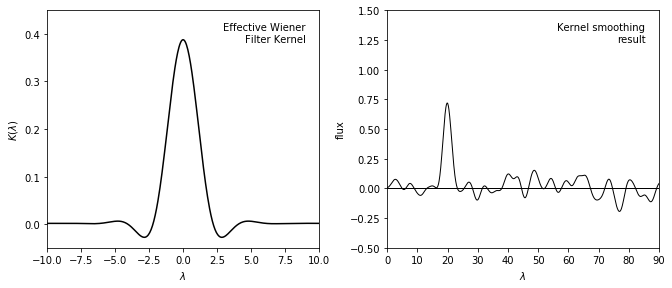

In [ ]:
# Plot the results
fig = plt.figure(figsize=(10, 4.4))
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.25,
                    bottom=0.15, top=0.9)

# First plot: the equivalent Kernel to the WF
ax = fig.add_subplot(121)
ax.plot(t_plot, kernel.real, '-k')
ax.text(0.95, 0.95, "Effective Wiener\nFilter Kernel",
        ha='right', va='top', transform=ax.transAxes)

ax.set_xlim(-10, 10)
ax.set_ylim(-0.05, 0.45)
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$K(\lambda)$')

# Second axes: Kernel smoothed results
ax = fig.add_subplot(122)
ax.plot(t_eval, h_smooth, '-k', lw=1)
ax.plot(t_eval, 0 * t_eval, '-k', lw=1)
ax.text(0.95, 0.95, "Kernel smoothing\nresult",
        ha='right', va='top', transform=ax.transAxes)

ax.set_xlim(0, 90)
ax.set_ylim(-0.5, 1.5)

ax.set_xlabel('$\lambda$')
ax.set_ylabel('flux')

plt.show()

## 2. High-pass filters
The most common example of high-pass filtering in astronomy is baseline estimation in spectral
data. Unlike the case of low-pass filtering, here there is no universal filter recipe. Baseline estimation
is usually the first step toward the estimation of model parameters (e.g. location, width, and strength of spectral lines). In such cases, the best approach might be full modeling and
marginalization of baseline parameters as nuisance parameters at the end of analysis.  
  
A simple iterative technique for high-pass filtering, called **minimum component filtering**, is discussed
in detail in WJ03. These are the **main steps**:
1. Determine baseline: exclude or mask regions where signal is clearly evident and fit a baseline
model (e.g., a low-order polynomial) to the unmasked regions.
2. Get FT for the signal: after subtracting the baseline fit in the unmasked regions (i.e., a linear
regression fit), apply the discrete Fourier transform.
3. Filter the signal: remove high frequencies using a low-pass filter (e.g., Wiener filter), and
inverse Fourier transform the result.
4. Recombine the baseline and the filtered signal: add the baseline fit subtracted in step 2 to
the result from step 3. This is the minimum component filtering estimate of baseline.  
  
In the next two examples, we will see the application of a minimum component filter to the spectrum of a white dwarf.

## Example 1 (Show steps)
### Fetch the data
We first fetch the spectrum data from SDSS database for use. The intermediate steps of the minimum component filter procedure applied to the spectrum of a white dwarf from the SDSS data set (mjd= 52199, plate=659, fiber=381).

In [ ]:
# Fetch the spectrum from SDSS database
plate = 659
mjd = 52199
fiber = 381

data = fetch_sdss_spectrum(plate, mjd, fiber)

lam = data.wavelength()
spec = data.spectrum

[========================================]  182.8kb / 182.8kb   
caching to /astro/users/zhaoz26/astroML_data/SDSSspec/0659/spSpec-52199-0659-381.fit


### Pre-process the data
Wavelengths we get are logorithmically spaced: we will work in log(lam).

In [ ]:
def preprocess(lam, spec):
    loglam = np.log10(lam)

    flag = (lam > 4000) & (lam < 5000)
    lam = lam[flag]
    loglam = loglam[flag]
    spec = spec[flag]

    lam = lam[:-1]
    loglam = loglam[:-1]
    spec = spec[:-1]
    
    return [lam, loglam, spec]

[lam, loglam, spec] = preprocess(lam, spec)

### Apply minimum component filtering steps

First step: mask-out significant features

In [ ]:
feature_mask = (((lam > 4080) & (lam < 4130)) |
                ((lam > 4315) & (lam < 4370)) |
                ((lam > 4830) & (lam < 4900)))

Second step: fit a line to the unmasked portion of the spectrum

In [ ]:
XX = loglam[:, None] ** np.arange(2)
beta = np.linalg.lstsq(XX[~feature_mask], spec[~feature_mask])[0]

spec_fit = np.dot(XX, beta)
spec_patched = spec - spec_fit
spec_patched[feature_mask] = 0

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


Third step: Fourier transform the patched spectrum

In [ ]:
N = len(loglam)
df = 1. / N / (loglam[1] - loglam[0])
f = fftpack.ifftshift(df * (np.arange(N) - N / 2.))
spec_patched_FT = fftpack.fft(spec_patched)

Fourth step: Low-pass filter on the transform

In [ ]:
filt = np.exp(- (0.01 * (abs(f) - 100.)) ** 2)
filt[abs(f) < 100] = 1

spec_filt_FT = spec_patched_FT * filt

Fifth step: inverse Fourier transform, and add back the fit

In [ ]:
spec_filt = fftpack.ifft(spec_filt_FT)
spec_filt += spec_fit

### Show filter result
* The top panel shows the input spectrum; the masked sections of the input spectrum are shown by thin lines (i.e., step 1 of the process). 
* The bottom panel shows the PSD of the masked spectrum, after the linear fit has been subtracted (gray line). 
* A simple low-pass filter (dashed line) is applied, and the resulting filtered spectrum (dark line) is used to construct the result shown in the next figure.

Text(0, 0.5, 'scaled $PSD(f)$')

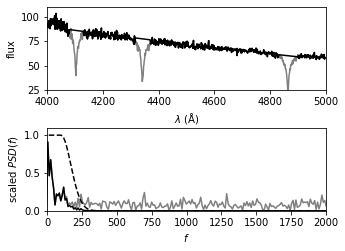

In [ ]:
# plot results
fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(hspace=0.45)

ax = fig.add_subplot(211)
ax.plot(lam, spec, '-', c='gray')
ax.plot(lam, spec_patched + spec_fit, '-k')

ax.set_ylim(25, 110)
ax.set_xlim(4000, 5000)

ax.set_xlabel(r'$\lambda\ {\rm(\AA)}$')
ax.set_ylabel('flux')

ax = fig.add_subplot(212)
factor = 15 * (loglam[1] - loglam[0])
ax.plot(fftpack.fftshift(f),
        factor * fftpack.fftshift(abs(spec_patched_FT) ** 1),
        '-', c='gray', label='masked/shifted spectrum')
ax.plot(fftpack.fftshift(f),
        factor * fftpack.fftshift(abs(spec_filt_FT) ** 1),
        '-k', label='filtered spectrum')
ax.plot(fftpack.fftshift(f),
        fftpack.fftshift(filt), '--k', label='filter')

ax.set_xlim(0, 2000)
ax.set_ylim(0, 1.1)

ax.set_xlabel('$f$')
ax.set_ylabel('scaled $PSD(f)$')

## Example 2 (use package)
### Fetch the data
We follow the same process to analyze the same white dwarf example. Here instead of explicitly applying steps, we call function *min_component_filter* to achieve the same goal.

In [ ]:
plate = 659
mjd = 52199
fiber = 381

data = fetch_sdss_spectrum(plate, mjd, fiber)

lam = data.wavelength()
spec = data.spectrum

### Pre-process the data

In [ ]:
[lam, loglam, spec] = preprocess(lam,spec)

### Apply minimum component filtering using function
The function used here is *min_component_filter* in *astroML.filters* package.

In [ ]:
feature_mask = (((lam > 4080) & (lam < 4130)) |
                ((lam > 4315) & (lam < 4370)) |
                ((lam > 4830) & (lam < 4900)))

spec_filtered = min_component_filter(loglam, spec, feature_mask, fcut=100)

### Compute PSD of filtered and unfiltered versions

In [ ]:
f, spec_filt_PSD = PSD_continuous(loglam, spec_filtered)
f, spec_PSD = PSD_continuous(loglam, spec)

### Show filter result
* The upper panel shows a portion of the input spectrum, along with the continuum computed via the minimum component filtering procedure described above (See the previous figure). 
* The lower panel shows the PSD for both the input spectrum and the filtered result.

In [ ]:
# Plot the results
fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(hspace=0.45)

# Top panel: plot noisy and smoothed spectrum
ax = fig.add_subplot(211)
ax.plot(lam, spec, '-', c='gray', lw=1)
ax.plot(lam, spec_filtered, '-k')

ax.text(0.97, 0.93, "SDSS white dwarf\n %i-%i-%i" % (mjd, plate, fiber),
        ha='right', va='top', transform=ax.transAxes)

ax.set_ylim(25, 110)
ax.set_xlim(4000, 5000)

ax.set_xlabel(r'$\lambda\ {\rm (\AA)}$')
ax.set_ylabel('flux')

# Bottom panel: plot noisy and smoothed PSD
ax = fig.add_subplot(212, yscale='log')
ax.plot(f, spec_PSD, '-', c='gray', lw=1)
ax.plot(f, spec_filt_PSD, '-k')

ax.set_xlabel(r'$f$')
ax.set_ylabel('$PSD(f)$')
ax.set_xlim(0, 2000)